# Course 2 Project: ML Pipeline for Feature Engineering

## Instructions

In this project, you'll use data related to microeconomic indicators and historical stock prices to explore the data engineering pipline. You'll get to practice:

* Data ingestion 
* Data cleaning
* Data imputation
* Exploratory data analysis (EDA) through charts and graphs

## Packages

You'll use `pandas` and `matplotlib`, which were covered in the course material, to import, clean, and plot data. They have been installed in this workspace for you. If you're working locally and you installed Jupyter using Anaconda, these packages will already be installed. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

The first step in a data engineering pipeline for machine learning is to ingest the data that will be used. For this project, data is hosted on a public GitHub repo. 

Your tasks:
* Import data from the provided GitHub repo using `pandas`
* Verify that the data has been imported correctly into `pandas` dataframes. Use methods like `head()` and `info()`
* You may need to change column names to make them easier to work with
* You may need to cast datetime data to the `datetime` format using `pandas` `to_datetime()` method

Data files to import: 
1. GDP
2. Inflation 
3. Apple stock prices 
4. Microsoft stock prices

Note: The dataset file names in alphabetic order

* apple_historical_data.csv

* consumer_price_index.csv

* GDP.csv

* inflation_monthly.csv

* microsoft_historical_data.csv 

In [2]:
# Load historical GDP data

gdp_data = pd.read_csv('GDP.csv')


In [3]:
inflation_data = pd.read_csv('inflation_monthly.csv')


In [4]:
cpi_data = pd.read_csv('consumer_price_index.csv')

In [5]:
# Check the first few rows of data
print(f'GDP (head):\n\n {gdp_data.head()}')
print('\n')
print(f'GDP (tail):\n\n {gdp_data.tail()}')

GDP (head):

          DATE      GDP
0  1947-01-01  243.164
1  1947-04-01  245.968
2  1947-07-01  249.585
3  1947-10-01  259.745
4  1948-01-01  265.742


GDP (tail):

            DATE        GDP
304  2023-01-01  26813.601
305  2023-04-01  27063.012
306  2023-07-01  27610.128
307  2023-10-01  27956.998
308  2024-01-01  28284.498


In [6]:
print(f'Inflation (head):\n\n {inflation_data.head()}')
print('\n')
print(f'Inflation (tail):\n\n {inflation_data.tail()}')

Inflation (head):

          DATE  CORESTICKM159SFRBATL
0  1968-01-01              3.651861
1  1968-02-01              3.673819
2  1968-03-01              4.142164
3  1968-04-01              4.155828
4  1968-05-01              4.088245


Inflation (tail):

            DATE  CORESTICKM159SFRBATL
670  2023-11-01              4.688293
671  2023-12-01              4.554396
672  2024-01-01              4.603922
673  2024-02-01              4.403102
674  2024-03-01              4.509212


In [7]:
print(f'Consumer Price Index (head):\n\n {cpi_data.head()}')
print('\n')
print(f'Consumer Price Index (tail):\n\n {cpi_data.tail()}')

Consumer Price Index (head):

          DATE  CORESTICKM159SFRBATL
0  1968-01-01              3.651861
1  1968-02-01              3.673819
2  1968-03-01              4.142164
3  1968-04-01              4.155828
4  1968-05-01              4.088245


Consumer Price Index (tail):

            DATE  CORESTICKM159SFRBATL
670  2023-11-01              4.688293
671  2023-12-01              4.554396
672  2024-01-01              4.603922
673  2024-02-01              4.403102
674  2024-03-01              4.509212


###  Rename columns for GDP,  Inflation and Consumer Price Index DataFrames

In [8]:
gdp_data.rename(columns={'DATE':'Date'}, inplace=True)
inflation_data.rename(columns={'DATE':'Date', 'CORESTICKM159SFRBATL':'monthly_Inflation'}, inplace=True)
cpi_data.rename(columns={'DATE':'Date', 'CORESTICKM159SFRBATL':'Daily_CPI'}, inplace=True)

In [9]:
# Load the historical stock price data for Apple and Microsoft
apple_data = pd.read_csv('apple_historical_data.csv')
                                                                 

In [10]:
msft_data = pd.read_csv('microsoft_historical_data.csv')


In [11]:
# Check the first few rows of data
print(f'AAPL (head):\n\n {apple_data.head()}')
print('\n')
print(f'AAPL (tail):\n\n {apple_data.tail()}')

AAPL (head):

         Date Close/Last     Volume      Open      High       Low
0   5/3/2024   $183.38   163224100  $186.65   $187.00   $182.66 
1   5/2/2024   $173.03    94214920  $172.51   $173.42   $170.89 
2   5/1/2024   $169.30    50383150  $169.58   $172.71   $169.11 
3  4/30/2024   $170.33    65934780  $173.33   $174.99   $170.00 
4  4/29/2024   $173.50    68169420  $173.37   $176.03   $173.10 


AAPL (tail):

            Date Close/Last     Volume     Open     High      Low
2512  5/12/2014    $21.17   212736019  $20.98   $21.20   $20.98 
2513   5/9/2014    $20.91   291068564  $20.88   $20.94   $20.73 
2514   5/8/2014    $21.00   228973884  $21.01   $21.23   $20.94 
2515   5/7/2014    $21.15   282128727  $21.26   $21.33   $20.99 
2516   5/6/2014    $21.23   373872650  $21.49   $21.59   $21.23 


In [12]:
print(f'MSFT (head):\n\n {msft_data.head()}')
print('\n')
print(f'MSFT (tail):\n\n {msft_data.tail()}')

MSFT (head):

          Date Close/Last    Volume     Open       High        Low
0  05/03/2024    $406.66  17446720  $402.28    $407.15    $401.86
1  05/02/2024    $397.84  17709360  $397.66    $399.93  $394.6515
2  05/01/2024    $394.94  23562480  $392.61  $401.7199    $390.31
3  04/30/2024    $389.33  28781370  $401.49    $402.16    $389.17
4  04/29/2024    $402.25  19582090  $405.25    $406.32    $399.19


MSFT (tail):

             Date Close/Last    Volume    Open    High     Low
2512  05/12/2014     $39.97  22761620  $39.74  $40.02  $39.65
2513  05/09/2014     $39.54  29646100  $39.54  $39.85  $39.37
2514  05/08/2014     $39.64  32089010  $39.34  $39.90  $38.97
2515  05/07/2014    $39.425  41731030  $39.22  $39.51  $38.51
2516  05/06/2014     $39.06  27105700  $39.29  $39.35  $38.95


### Rename AAPL and MSFT   'Close/Last' column to just 'Close'

In [13]:
# renaming the close 'Close/Last' column to just 'Close'
apple_data.rename(columns={'Close/Last':'Close'}, inplace=True)
msft_data.rename(columns={'Close/Last':'Close'}, inplace=True)

In [14]:
apple_data

,Date,Close,Volume,Open,High,Low
0,5/3/2024,$183.38,163224100,$186.65,$187.00,$182.66
1,5/2/2024,$173.03,94214920,$172.51,$173.42,$170.89
2,5/1/2024,$169.30,50383150,$169.58,$172.71,$169.11
3,4/30/2024,$170.33,65934780,$173.33,$174.99,$170.00
4,4/29/2024,$173.50,68169420,$173.37,$176.03,$173.10
...,...,...,...,...,...,...
2512,5/12/2014,$21.17,212736019,$20.98,$21.20,$20.98
2513,5/9/2014,$20.91,291068564,$20.88,$20.94,$20.73
2514,5/8/2014,$21.00,228973884,$21.01,$21.23,$20.94
2515,5/7/2014,$21.15,282128727,$21.26,$21.33,$20.99


In [15]:
msft_data

,Date,Close,Volume,Open,High,Low
0,05/03/2024,$406.66,17446720,$402.28,$407.15,$401.86
1,05/02/2024,$397.84,17709360,$397.66,$399.93,$394.6515
2,05/01/2024,$394.94,23562480,$392.61,$401.7199,$390.31
3,04/30/2024,$389.33,28781370,$401.49,$402.16,$389.17
4,04/29/2024,$402.25,19582090,$405.25,$406.32,$399.19
...,...,...,...,...,...,...
2512,05/12/2014,$39.97,22761620,$39.74,$40.02,$39.65
2513,05/09/2014,$39.54,29646100,$39.54,$39.85,$39.37
2514,05/08/2014,$39.64,32089010,$39.34,$39.90,$38.97
2515,05/07/2014,$39.425,41731030,$39.22,$39.51,$38.51


In [16]:
# Use methods like .info() and .describe() to explore the data

gdp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    309 non-null    object 
 1   GDP     309 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [17]:
gdp_data.describe()

,GDP
count,309.000000
mean,7227.754935
std,7478.297734
min,243.164000
25%,804.981000
50%,4386.773000
75%,12527.214000
max,28284.498000


## Data preprocessing: Check for missing data and forward fill

Check the Apple historical prices for missing data. Check for missing data in all columns. If there's data missing, use a forward fill to fill in those missing prices. 

In [18]:
# Check for nulls 
apple_data.isnull().sum()

Date      0
Close     3
Volume    0
Open      0
High      0
Low       0
dtype: int64

In [19]:
# Forward fill any missing data
df_columns = apple_data.columns.tolist()
for col in df_columns:
    if apple_data[col].isnull().sum() != 0:
        apple_data[col] = apple_data[col].ffill()


In [20]:
# Check again for nulls after using forward fill
apple_data.isnull().sum()

Date      0
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64

## Data preprocessing: Remove special characters and convert to numeric/datetime

The next step in the data engineering process is to standardize and clean up data. In this step, you'll check for odd formatting and special characters that will make it difficult to work with data as numeric or datetime. 

In this step:
* Create a function that takes in a dataframe and a list of columns and removes dollar signs ('$') from those columns
* Convert any columns with date/time data into a `pandas` `datetime` format

In [21]:
def convert_dollar_columns_to_numeric(df, numeric_columns):
    '''
        Removes dollar signs ('$') from a list of columns in a given dataframe AND casts the columns to a numeric datatype.
        Updates dataframe IN PLACE.
        
        Inputs:
            df: dataframe to be operated on
            numeric_columns: columns that should have numeric data but have dollar signs currently
            
        Returns:
            None - changes to the dataframe can be made in place
    '''
    
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col].str.replace('$', ''))
    
    
   # pass 

## Test copy the data  to testing tasks

From here, I think, it is a good practice to copy the undelying DataFrames to new ones. Indeed, this will help us avoid going back to re-download the data again and again. 

In [22]:
# copy apple and microsofte dfs

cp_apple_data = apple_data.copy()
cp_msft_data = msft_data.copy()

In [23]:
# copy macro-economic dfs

cp_inflation_data = inflation_data.copy()
cp_gdp_data = gdp_data.copy()
cp_cpi_data = cpi_data.copy()

In [24]:
cp_apple_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2517 non-null   object
 1   Close   2517 non-null   object
 2   Volume  2517 non-null   int64 
 3   Open    2517 non-null   object
 4   High    2517 non-null   object
 5   Low     2517 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [25]:
cp_gdp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    309 non-null    object 
 1   GDP     309 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [26]:
# Use convert_dollar_columns_to_numeric() to remove the dollar sign from the Apple and Microsoft datasets

list_dollar_sign_columns  = apple_data.drop(['Date', 'Volume'], axis=1).columns.tolist()
list_dollar_sign_columns

convert_dollar_columns_to_numeric(cp_apple_data, list_dollar_sign_columns)

convert_dollar_columns_to_numeric(cp_msft_data, list_dollar_sign_columns)

In [27]:
print(f'Removed "$" AAPL:\n\n {cp_apple_data.head()}')

print('\n')

print(f'Removed "$" MSFT:\n\n {cp_msft_data.head()}')

Removed "$" AAPL:

         Date   Close     Volume    Open    High     Low
0   5/3/2024  183.38  163224100  186.65  187.00  182.66
1   5/2/2024  173.03   94214920  172.51  173.42  170.89
2   5/1/2024  169.30   50383150  169.58  172.71  169.11
3  4/30/2024  170.33   65934780  173.33  174.99  170.00
4  4/29/2024  173.50   68169420  173.37  176.03  173.10


Removed "$" MSFT:

          Date   Close    Volume    Open      High       Low
0  05/03/2024  406.66  17446720  402.28  407.1500  401.8600
1  05/02/2024  397.84  17709360  397.66  399.9300  394.6515
2  05/01/2024  394.94  23562480  392.61  401.7199  390.3100
3  04/30/2024  389.33  28781370  401.49  402.1600  389.1700
4  04/29/2024  402.25  19582090  405.25  406.3200  399.1900


In [28]:
# Use pandas's to_datetime() to convert any columns that are in a datetime format

# function
def convert_to_datetime(df):
    '''
        check every column, verify if type is object and convert to datetime in case of datetime format
    '''
    for col in df.columns:
        if pd.api.types.is_object_dtype(df[col]):
            try:
                df[col] = pd.to_datetime(df[col])
            except (ValueError, TypeError):
                pass


convert_to_datetime(cp_apple_data)
convert_to_datetime(cp_msft_data)
convert_to_datetime(cp_inflation_data)
convert_to_datetime(cp_gdp_data)
convert_to_datetime(cp_cpi_data)


In [29]:
# Use .info() and check the type of each column to ensure that the above steps worked

cp_apple_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Close   2517 non-null   float64       
 2   Volume  2517 non-null   int64         
 3   Open    2517 non-null   float64       
 4   High    2517 non-null   float64       
 5   Low     2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [30]:
cp_msft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Close   2517 non-null   float64       
 2   Volume  2517 non-null   int64         
 3   Open    2517 non-null   float64       
 4   High    2517 non-null   float64       
 5   Low     2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [31]:
cp_inflation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               675 non-null    datetime64[ns]
 1   monthly_Inflation  675 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 KB


## Data preprocessing: Align datetime data

Data engineering includes changing data with a datetime component if needed so that different time series can be more easily compared or plotted against each other. 

In this step:

* Align the inflation date so that it falls on the last day of the month instead of the first

Helpful hints: 
* Use the `pandas` `offsets` method using `MonthEnd(0)` to set the 'Date' column to month-end

In [32]:
cp_inflation_data.head()

,Date,monthly_Inflation
0,1968-01-01,3.651861
1,1968-02-01,3.673819
2,1968-03-01,4.142164
3,1968-04-01,4.155828
4,1968-05-01,4.088245


In [33]:
# Align inflation data so that the date is the month end (e.g. Jan 31, Feb 28/28)

cp_inflation_data['Date'] = cp_inflation_data['Date'] + pd.offsets.MonthEnd(0)

In [34]:
cp_inflation_data.head()

,Date,monthly_Inflation
0,1968-01-31,3.651861
1,1968-02-29,3.673819
2,1968-03-31,4.142164
3,1968-04-30,4.155828
4,1968-05-31,4.088245


## Data preprocessing: Upsample, downsample and interpolate data

Inflation data is presented monthly in this dataset. However, for some models, you may need it at a quarterly frequency, and for some models you may need it at a quarterly (weekly ?) frequency. 

In this step:
* Create a new quarterly inflation dataframe by downsampling the monthly inflation data to quarterly using the mean (e.g. for quarter 1 in a given year, use the average values from January, February, and March)
* Create a new weekly inflation dataframe by upsampling the monthly inflation data. For this, you'll need to use `resample` and then you'll need to `interpolate` to fill in the missing data at the weekly frequency

Note that you may need to change the index for some of these operations! 

In [35]:
# Upsample and interpolate from monthly to weekly 

weekly_inflation_data = cp_inflation_data.set_index('Date')\
                                .resample('W')\
                                .interpolate(method='linear')\
                                .rename(columns={'monthly_Inflation':'weekly_inflation'})\
                                .dropna()
weekly_inflation_data

,weekly_inflation
Date,
1968-03-31,4.142164
1968-04-07,4.173195
1968-04-14,4.204226
1968-04-21,4.235258
1968-04-28,4.266289
...,...
2024-03-03,4.523115
2024-03-10,4.519639
2024-03-17,4.516164


In [36]:
# Downsample from monthly to quarterly 

quaterly_inflation_data = cp_inflation_data.set_index('Date')\
                                    .resample('QE')\
                                    .mean()\
                                    .rename(columns={'monthly_Inflation':'quaterly_Inflation'})\
                                    .dropna()
quaterly_inflation_data

,quaterly_Inflation
Date,
1968-03-31,3.822615
1968-06-30,4.263214
1968-09-30,4.882643
1968-12-31,5.429443
1969-03-31,5.873770
...,...
2023-03-31,6.467833
2023-06-30,5.942054
2023-09-30,5.179249


## Data preprocessing: Normalize/standardize a feature

Economic time series data often involve variables measured on different scales (e.g., GDP in trillions of dollars, inflation in percentage points). Standardizing these variables (typically by subtracting the mean and dividing by the standard deviation) puts them on a common scale, allowing for meaningful comparisons and analyses.

Your task:
* Standardize the GDP data. You may do this manually by subtracting the mean and dividing by the standard deviation, or you may use a built-in method from a library like `sklearn`'s `StandardScaler`

In [37]:
# Standardize the GDP measure

#Option 1: manually

cp_gdp_data.set_index('Date', inplace=True)

manually_gdp_strd = cp_gdp_data.copy()

manually_gdp_strd = manually_gdp_strd.sub(manually_gdp_strd.mean()).div(manually_gdp_strd.std())

manually_gdp_strd

,GDP
Date,
1947-01-01,-0.933981
1947-04-01,-0.933606
1947-07-01,-0.933123
1947-10-01,-0.931764
1948-01-01,-0.930962
...,...
2023-01-01,2.619025
2023-04-01,2.652376
2023-07-01,2.725536


In [38]:
# option 2: ML

!pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()
print(scaler.fit(cp_gdp_data))

cp_gdp_data = pd.DataFrame(scaler.transform(cp_gdp_data).flatten(), 
             columns=['GDP'],
            index=[cp_gdp_data.index])

StandardScaler()


In [41]:
# Check the dataframe to make sure the calculation worked as expected 

print(f'Mean GDP:\n\n {round(cp_gdp_data.mean(), 2)}')
print('\n')
print(f'Standard deviation GDP:\n\n {round(cp_gdp_data.std(), 2)}')
print('\n')
print(f'standardized GDP (head):\n\n {cp_gdp_data.head()}')
print('\n')
print(f'standardized GDP (tail):\n\n {cp_gdp_data.tail()}')

Mean GDP:

 GDP   -0.0
dtype: float64


Standard deviation GDP:

 GDP    1.0
dtype: float64


standardized GDP (head):

                  GDP
Date                
1947-01-01 -0.935496
1947-04-01 -0.935121
1947-07-01 -0.934636
1947-10-01 -0.933276
1948-01-01 -0.932472


standardized GDP (tail):

                  GDP
Date                
2023-01-01  2.623273
2023-04-01  2.656678
2023-07-01  2.729957
2023-10-01  2.776416
2024-01-01  2.820281


## EDA: Plotting a time series of adjusted open vs close price

As part of your EDA, you'll frequently want to plot two time series on the same graph and using the same axis to compare their movements. 

Your task:
* Plot the Apple open and close price time series on the same chart **for the last three months only**. Be sure to use a legend to label each line

**NOTE**: This is a large dataset. If you try to plot the entire series, your graph will be hard to interpret and may take a long time to plot. Be sure to use only the most recent three months of data. 

In [42]:
# Get max date in timeseries

cp_apple_data.set_index('Date', inplace=True) # set date as index
cp_apple_data.sort_index(ascending=False, inplace=True) # sort index

cp_msft_data.set_index('Date', inplace=True)
cp_msft_data.sort_index(ascending=False, inplace=True)

# alert for index similarity between aapl and msft
assert cp_apple_data.index.equals(cp_msft_data.index), "Not the same datetime index"

# get max date
max_date = cp_apple_data.index.max()
max_date

Timestamp('2024-05-03 00:00:00')

In [43]:
cp_apple_data.head()

,Close,Volume,Open,High,Low
Date,,,,,
2024-05-03,183.38,163224100,186.65,187.00,182.66
2024-05-02,173.03,94214920,172.51,173.42,170.89
2024-05-01,169.30,50383150,169.58,172.71,169.11
2024-04-30,170.33,65934780,173.33,174.99,170.00
2024-04-29,173.50,68169420,173.37,176.03,173.10


In [44]:
cp_msft_data.head()

,Close,Volume,Open,High,Low
Date,,,,,
2024-05-03,406.66,17446720,402.28,407.1500,401.8600
2024-05-02,397.84,17709360,397.66,399.9300,394.6515
2024-05-01,394.94,23562480,392.61,401.7199,390.3100
2024-04-30,389.33,28781370,401.49,402.1600,389.1700
2024-04-29,402.25,19582090,405.25,406.3200,399.1900


In [45]:
# Use the max date calculated above to get the last three months of data in the dataset 

apple_data_three_month = cp_apple_data.loc[max_date:max_date - pd.DateOffset(months=3), :]
msft_data_three_month = cp_msft_data.loc[max_date:max_date - pd.DateOffset(months=3), :]


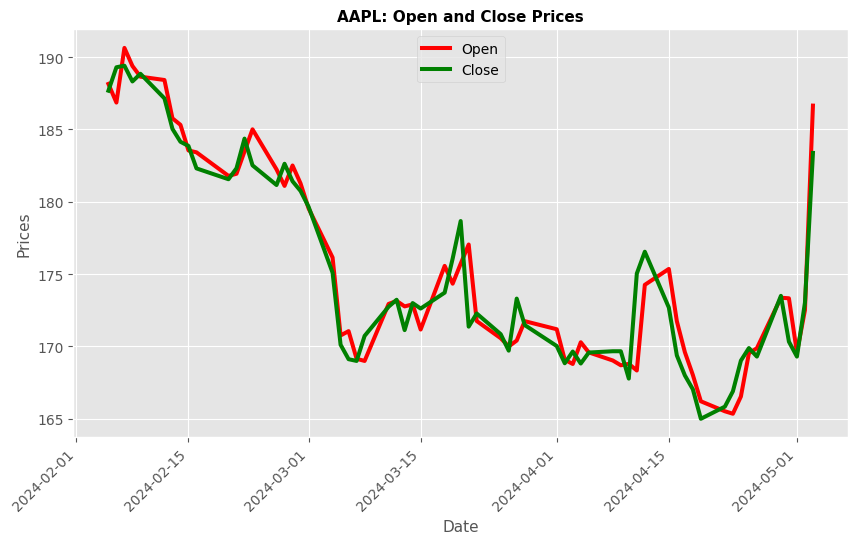

In [46]:
# Plot time series of open v. close stock price for Apple using the last 3 months of data
plt.style.use('ggplot')

apple_data_three_month[['Open', 'Close']].plot(figsize=(10, 6), color = ['red', 'green'], linewidth=2.9)
plt.title('AAPL: Open and Close Prices', fontsize=11, fontweight='bold')
plt.xlabel('Date', fontsize=11)
plt.ylabel('Prices', fontsize=11)
plt.legend(['Open', 'Close'], loc='upper center')

plt.xticks(rotation=45)

plt.show()

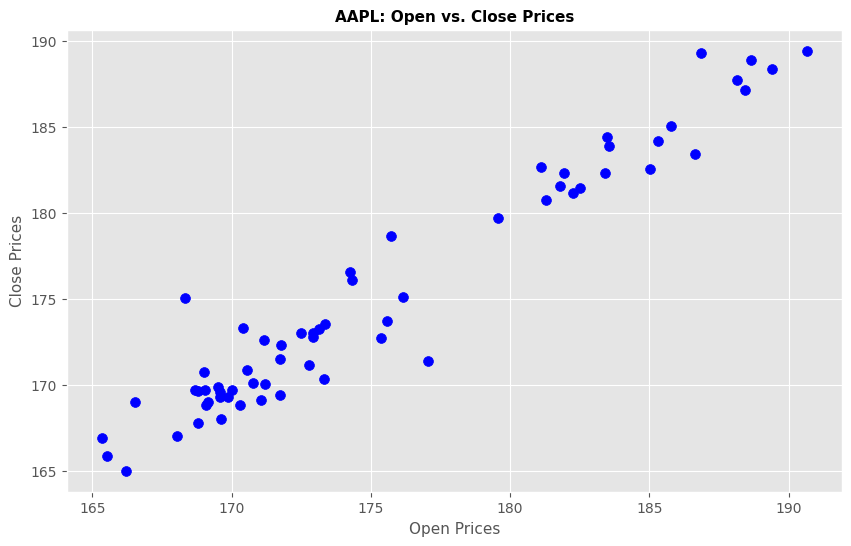

In [47]:
apple_data_three_month[['Open', 'Close']].plot.scatter(x='Open', y='Close', 
                                                       color='blue', 
                                                       figsize=(10, 6), s=50)

plt.title('AAPL: Open vs. Close Prices', fontsize=11, fontweight='bold')
plt.xlabel('Open Prices', fontsize=11)
plt.ylabel('Close Prices', fontsize=11)
plt.show()
plt.show()

## EDA: Plotting a histogram of a stock's closing price in the last three months

One way to see how much a stock's price generally moves is to plot the frequency of closing prices over a set time period. 

Your task:
* Use the **last three months** of Apple stock data and plot a histogram of closing price

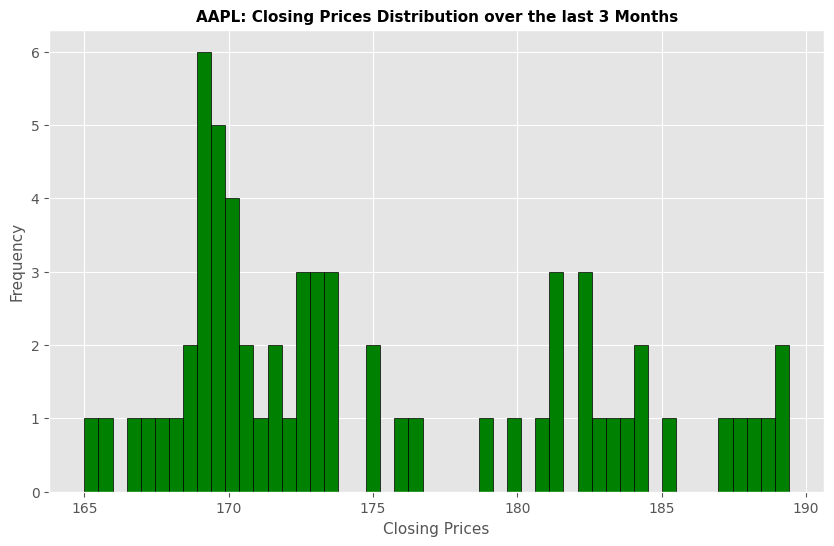

In [48]:
# Plot the histogram of Apple's closing price over the last 3 months 

apple_data_three_month['Close'].plot.hist(bins=50, color='green', edgecolor='black', figsize=(10, 6))
plt.xlabel('Closing Prices', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('AAPL: Closing Prices Distribution over the last 3 Months', fontsize=11, fontweight='bold')
plt.show()

## Calculating correlation between a stock price and a macroeconomic variable 

Inflation affects the purchasing power of money and can influence corporate profits, interest rates, and consumer behavior. By analyzing the correlation between stock prices and inflation, one can gauge how inflationary trends impact stock market performance. For instance, high inflation might erode profit margins and reduce stock prices, while moderate inflation might indicate a growing economy, benefiting stocks.

Your task:
* Plot a heatmap that shows the correlation between Microsoft and Apple returns and inflation 

This will require several steps:
1. Calculate the returns for Apple and Microsoft and the change in monthly inflation (use the `pct_change` method for each)
2. Interpolate the daily stock returns data to monthly so it can be compared to the monthly inflation data
3. Merge the stock returns (Apple and Microsoft) and inflation data series into a single dataframe
4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change
5. Plot the correlation matrix as a heatmap

### 1. Calculate returns for Microsoft / Apple and the monthly change in inflation

In [49]:
# Calculate daily returns for Apple and Microsoft and the percent change in inflation from month to month

# aapl
aapl_daily_ret = cp_apple_data.pct_change(1).dropna()[['Close']]
aapl_daily_ret.rename(columns={'Close':'aapl_1_d_ret'}, inplace=True)

# msft
msft_daily_ret =  cp_msft_data.pct_change(1).dropna()[['Close']]
msft_daily_ret.rename(columns={'Close':'msft_1_d_ret'}, inplace=True)

# inflation
inflation_monthly_ret = cp_inflation_data\
            .set_index('Date')\
            .pct_change(1)\
            .dropna()\
            .rename(columns={'monthly_Inflation':'infla_1_month_ret'})


In [50]:
inflation_monthly_ret

,infla_1_month_ret
Date,
1968-02-29,0.006013
1968-03-31,0.127482
1968-04-30,0.003299
1968-05-31,-0.016262
1968-06-30,0.111863
...,...
2023-11-30,-0.039860
2023-12-31,-0.028560
2024-01-31,0.010874


In [51]:
aapl_daily_ret

,aapl_1_d_ret
Date,
2024-05-02,-0.056440
2024-05-01,-0.021557
2024-04-30,0.006084
2024-04-29,0.018611
2024-04-26,-0.024207
...,...
2014-05-12,-0.001886
2014-05-09,-0.012282
2014-05-08,0.004304


### 2. Interpolate stock returns from daily to monthly

In [52]:
# aapl
aapl_monthly_ret = aapl_daily_ret\
                    .resample('ME')\
                    .mean()\
                    .interpolate(method='linear')\
                    .dropna()\
                    .rename(columns={'aapl_1_d_ret':'aapl_monthly_ret'})

#msft
msft_monthly_ret =  msft_daily_ret\
                    .resample('ME')\
                    .mean()\
                    .interpolate(method='linear')\
                    .dropna()\
                    .rename(columns={'msft_1_d_ret':'msft_monthly_ret'})

In [53]:
msft_monthly_ret

,msft_monthly_ret
Date,
2014-05-31,-0.002371
2014-06-30,-0.001205
2014-07-31,-0.001012
2014-08-31,-0.002388
2014-09-30,-0.000798
...,...
2024-01-31,-0.003988
2024-02-29,-0.001360
2024-03-31,-0.000991


### 3. Merge the dataframes and calculate / plot the correlation

In [54]:
merged_df = pd.merge(msft_monthly_ret, inflation_monthly_ret, left_index=True, right_index=True, how='inner')
merged_df = pd.merge(merged_df, aapl_monthly_ret, left_index=True, right_index=True, how='inner')

### 4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change

In [55]:
# Calculate correlation matrix

corr = merged_df.corr()
corr.style.background_gradient()

,msft_monthly_ret,infla_1_month_ret,aapl_monthly_ret
msft_monthly_ret,1.000000,0.063574,0.646676
infla_1_month_ret,0.063574,1.000000,0.045752
aapl_monthly_ret,0.646676,0.045752,1.000000


In [56]:
import numpy as np
sns.set_style('white')

### 5. Plot the correlation matrix as a heatmap 

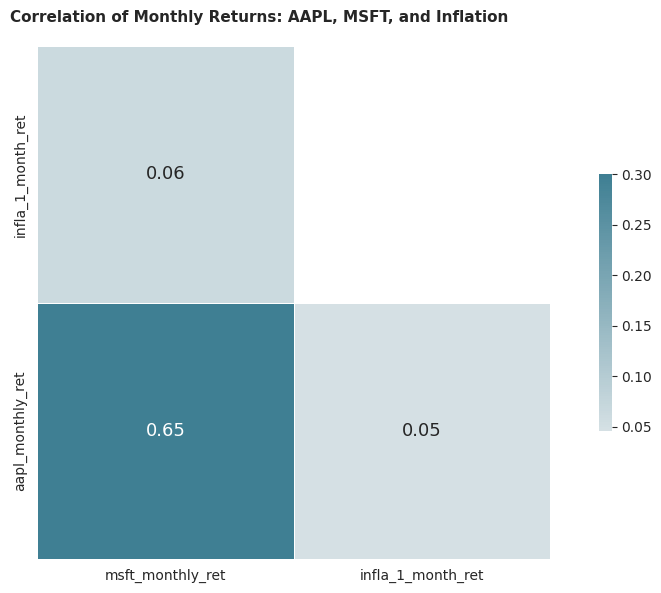

In [57]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(10, 6))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, 
            mask=mask,
            cmap=cmap,
            vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True, fmt='.2f',
            annot_kws={"size": 13})

plt.xticks(rotation=0)
fig.suptitle('Correlation of Monthly Returns: AAPL, MSFT, and Inflation', fontsize=11, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=.92)

## Calculating rolling volatility (standard deviation) of a stock's price for last 3 months

Volatility is a measure of the dispersion of returns for a given security. By calculating rolling volatility, investors can assess the risk associated with a stock over time: Higher volatility indicates higher risk, as the stock's price is more likely to experience significant fluctuations. In portfolio optimization, understanding the volatility of individual stocks and how it changes over time is crucial for diversification and optimization. By analyzing rolling volatility, investors can adjust their portfolios to maintain a desired risk level, potentially improving the risk-return profile.

One possible way to calculate volatility is by using the standard deviation of returns for a stock over time.

Your task:
* Calculate the weekly rolling standard deviation for Apple's closing price
* Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price. Plot these **on the same chart, but using different y-axes**

Helpful hints:
* You'll need to use the `pandas` `rolling()` method with a given `window_size` parameter to make it a _weekly_ rolling calculation
* Use **only the last three months of data**; data much older than this may not be as useful for portfolio optimization
* You'll need to create two axes on the matplotlib figure to be able to use two different y-axes (one for the closing price and one for the rolling volatility calculated here)

In [58]:
# Define the window size for the rolling calculation (e.g., one week)
window_size = 7

In [59]:
# Calculate rolling one-week volatility
apple_weekly_vol = apple_data_three_month[['Close']].pct_change()\
                            .dropna()\
                            .rolling(window=window_size)\
                            .std()\
                            .dropna()\
                            .rename(columns={'Close':'Weekly_Vol'})


In [60]:
apple_data_three_month

,Close,Volume,Open,High,Low
Date,,,,,
2024-05-03,183.38,163224100,186.65,187.00,182.66
2024-05-02,173.03,94214920,172.51,173.42,170.89
2024-05-01,169.30,50383150,169.58,172.71,169.11
2024-04-30,170.33,65934780,173.33,174.99,170.00
2024-04-29,173.50,68169420,173.37,176.03,173.10
...,...,...,...,...,...
2024-02-09,188.85,45155220,188.65,189.99,188.00
2024-02-08,188.32,40962050,189.39,189.54,187.35
2024-02-07,189.41,53438960,190.64,191.05,188.61


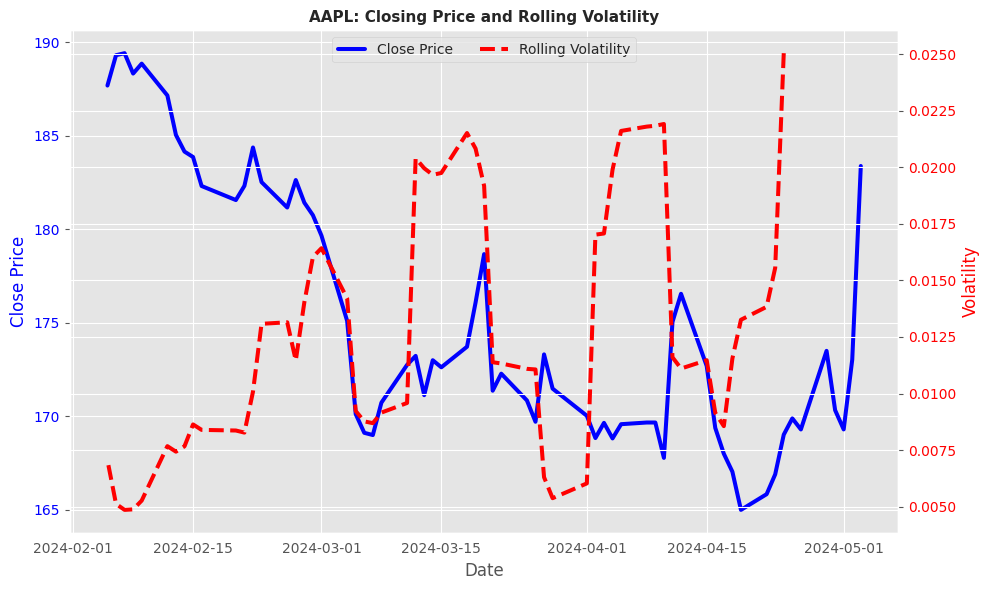

In [61]:
# Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price
# Plot these on the same chart, but using different y-axes

plt.style.use('ggplot')

fig, ax1 = plt.subplots(figsize=(10, 6))

line1, = ax1.plot(apple_data_three_month.index,  
                  apple_data_three_month['Close'], 
                  label='Close Price', 
                  color='blue',
                 linewidth=2.9)

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
line2, = ax2.plot(apple_weekly_vol.index, 
                  apple_weekly_vol['Weekly_Vol'], 
                  label='Rolling Volatility', 
                  color='red', 
                  linestyle='--',
                 linewidth=2.9)
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines = [line1, line2]
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels, loc='upper center', ncol=2)


plt.title('AAPL: Closing Price and Rolling Volatility', fontsize=11, fontweight='bold')
plt.tight_layout()

plt.show()



## Export data

Now that you have preprocessed your data, you should save it in new csv files so that it can be used in downstream tasks without having to redo all the preprocessing steps. 

Your task:
* Use `pandas` to export all modified datasets back to new CSV files

In [62]:
# saving  stock data
cp_apple_data.to_csv('preprocessed_apple_data.csv')
cp_msft_data.to_csv('preprocessed_microsoft_data.csv')
apple_data_three_month.to_csv('apple_three_month.csv')
msft_data_three_month.to_csv('msft_three_month.csv')

# saving macro-economics data
cp_cpi_data.to_csv('preprocessed_cpi_data.csv')
cp_gdp_data.to_csv('preprocessed_gdp_data.csv')
cp_inflation_data.to_csv('preprocessed_inflation_data.csv')


merged_df.to_csv('merged_apple_msft_inflation.csv')
